# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import torch
from collections import deque
from random import random

import threading
from time import sleep, time, strftime, gmtime

import matplotlib.pyplot as plt

from ddpg_agent import Agent, ReplayBuffer

In [8]:
class Params:
    def __init__(self):
        self.NUM_AGENTS = num_agents # Number of agents
        self.STATE_SIZE = state_size # Size of the state
        self.ACTION_SIZE = action_size # Size of actions        
        self.BUFFER_SIZE = int(5e5)  # replay buffer size
        self.BATCH_SIZE = 512        # minibatch size
        self.GAMMA = 0.99            # discount factor
        self.TAU = 1e-3              # for soft update of target parameters
        self.LR_ACTOR = 1e-4         # learning rate of the actor 
        self.LR_CRITIC = 1e-3        # learning rate of the critic
        self.WEIGHT_DECAY_ACTOR = 0  # L2 weight decay for the actor
        self.WEIGHT_DECAY_CRITIC = 0 # L2 weight decay for the critic

        self.NOISE_THETA=0.15        # Theta for noise
        self.NOISE_SIGMA=0.2         # Sigma for noise        
        
        self.SEED = 1
        
params = Params()

In [9]:
agent = Agent(params)
memory = ReplayBuffer(num_agents = params.NUM_AGENTS, buffer_size = params.BUFFER_SIZE, seed = params.SEED)

run_training = True

In [10]:
def train(experiences):
    """Update policy and value parameters using given batch of experience tuples.
    Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
    where:
        actor_target(state) -> action
        critic_target(state, action) -> Q-value
        
    It updates paramteres for all agents and all actor/critic networks

    Params
    ======
        experiences - one memory sample
    """

    states0, actions0, rewards0, next_states0, dones0 = experiences[0]
    states1, actions1, rewards1, next_states1, dones1 = experiences[1]

    # Get predicted next-state actions
    with torch.no_grad():
        next_actions0 = agent.actor_target(next_states0)
        next_actions1 = agent.actor_target(next_states1)
    
    
    if True:#random() < 0.5: # Agent1 perspective     
        agent.learn(states0, actions0, rewards0, next_states0, dones0,
                    next_actions0,
                    states1, actions1, next_states1, 
                    next_actions1, 
                   )
    if True: # Agent 2 perspective
        agent.learn(states1, actions1, rewards1, next_states1, dones1,
                    next_actions1,
                    states0, actions0, next_states0, 
                    next_actions0
                   )
    

In [11]:
def train_agent():
    exp_time = 0
    learn_time = 0
    while True:
        if len(memory) > params.BATCH_SIZE:
            break
        sleep(1)

    while run_training:
        experiences = memory.sample(params.BATCH_SIZE)
        
        train(experiences)
        agent.learning_step += 1

    print ("Training agent done!")    
    

In [12]:
def generate_episodes(n_episodes=10000, scores_threshold = 2.0, max_train_time = 3600,
                      print_every=100, save_every=1000,
                      noise_max = 0.1, noise_min = 0.05, min_noise_level = 1.5):
    """
    Arguments:
        n_episodes       - number of episodes
        scores_threshold - score threshold that shows when to stop the training
        max_train_time   - maximum trainnig duration (in seconds)
        print_every      - how often the information shall be printed (n. of episodes)
        save_every       - how often the models shall be saved (n. of episodes)
        noise_max        - maximum sigma for noise generation
        noise_min        - minimum sigma for noise generation
        min_noise_level  - averaged score that corresponds to minimum sigma for noise generation
    """
    
    global run_training
    
    t = time()
    scores_deque = deque(maxlen=100)
    scores = []
    scores_mean = 0
    
    env_step = 0
    noise_sigma = noise_max
    
    print ('Running experiments...')
    
    i_episode = 0
    while ((i_episode <= n_episodes) and 
           (scores_mean < scores_threshold) and
           (time() - t < max_train_time)):
           
        i_episode += 1
        #train_mode = i_episode % save_every != 0
        train_mode = True
        env_info = env.reset(train_mode=train_mode)[brain_name]   
        states = env_info.vector_observations      
        ep_scores = np.zeros(params.NUM_AGENTS)
        #agent.reset() # needed only with OU noise
        while True:
            actions_ag1 = agent.act(states[0], add_noise='rand', sigma = noise_sigma)
            actions_ag2 = agent.act(states[1], add_noise='rand', sigma = noise_sigma)
            env_info = env.step(np.concatenate((actions_ag1, actions_ag2), axis=0))[brain_name]
            actions = np.vstack((actions_ag1, actions_ag2))
            next_states = env_info.vector_observations        
            rewards = env_info.rewards                       
            dones = env_info.local_done 
            memory.add(states, actions, rewards, next_states, dones)
            states = next_states
            ep_scores += rewards
            env_step += 1          
            
            if np.any(dones):
                break 
            
        score = max(ep_scores)
        
        scores_deque.append(score)
        scores.append(score)
        
        scores_mean = np.mean(scores_deque)
        
        
        print('\rEpisode {:,}\tEnv steps/Learning step: {:.2f}\tSigma: {:.2f}\tAvg. Score: {:.2f} ({}s)'.format(
            i_episode, (env_step/agent.learning_step if agent.learning_step > 0 else np.inf),
            noise_sigma, scores_mean,
            strftime('%H:%M:%S', gmtime(time() - t))
        ), end="")
        
        noise_sigma = noise_min + max(0, min_noise_level - scores_mean) * (noise_max - noise_min) / min_noise_level
        
        if i_episode % print_every == 0:
            print('\rEpisode {:,}\tEnv steps/Learning step: {:.2f}\tSigma: {:.2f}\tAvg. Score: {:.2f} ({}s)'.format(
                i_episode, (env_step/agent.learning_step if agent.learning_step > 0 else np.inf),
                noise_sigma, scores_mean,
                strftime('%H:%M:%S', gmtime(time() - t))
            ))

        if i_episode % save_every == 0:
            torch.save(agent.actor_local.state_dict(), './models/checkpoint_actor_{}.pth'.format(i_episode))
            torch.save(agent.critic_local.state_dict(), './models/checkpoint_critic_{}.pth'.format(i_episode))
    
    torch.save(agent.actor_local.state_dict(), './models/checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), './models/checkpoint_critic.pth')    
    
    run_training = False
           
    print ('\n{:,} experiences were added to replay buffer.'.format(env_step))
    return scores

Running experiments...
Episode 100	Env steps/Learning step: 16.24	Sigma: 0.10	Avg. Score: 0.00 (00:00:11s)
Episode 200	Env steps/Learning step: 11.97	Sigma: 0.10	Avg. Score: 0.00 (00:00:23s)
Episode 300	Env steps/Learning step: 10.83	Sigma: 0.10	Avg. Score: 0.01 (00:00:36s)
Episode 400	Env steps/Learning step: 10.25	Sigma: 0.10	Avg. Score: 0.04 (00:00:54s)
Episode 500	Env steps/Learning step: 10.07	Sigma: 0.10	Avg. Score: 0.00 (00:01:06s)
Episode 600	Env steps/Learning step: 9.95	Sigma: 0.10	Avg. Score: 0.00 (00:01:17s))
Episode 700	Env steps/Learning step: 9.85	Sigma: 0.10	Avg. Score: 0.00 (00:01:29s)
Episode 800	Env steps/Learning step: 9.79	Sigma: 0.10	Avg. Score: 0.00 (00:01:41s)
Episode 900	Env steps/Learning step: 9.74	Sigma: 0.10	Avg. Score: 0.00 (00:01:53s)
Episode 1,000	Env steps/Learning step: 9.68	Sigma: 0.10	Avg. Score: 0.04 (00:02:14s)
Episode 1,100	Env steps/Learning step: 9.65	Sigma: 0.10	Avg. Score: 0.00 (00:02:26s)
Episode 1,200	Env steps/Learning step: 9.64	Sigma: 0.1

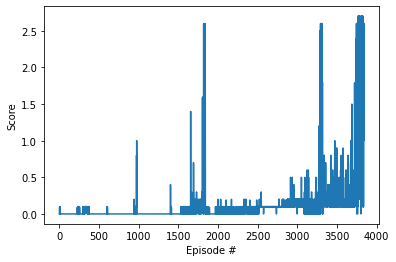

Training agent done!


In [13]:
run_training = True
t1 = threading.Thread(target=train_agent)
t1.start()


scores = generate_episodes()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
# Saving scores for further analysis
import pickle
pickle.dump(scores, open('./scores.p', 'wb'))

In [15]:
print ('Agent performed {:,} learning steps'.format(agent.learning_step))

Agent performed 22,134 learning steps


In [16]:
env.close()

In [17]:
pickle.dump(params, open('./params.p', 'wb'))